In [3]:
import os
import cv2
import sys
import glob
import json
import torch
import random
import datetime
import openslide
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm

from torchvision.utils import make_grid
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, Dataset

from monai.losses import DiceCELoss

In [4]:
# ASAP for python
sys.path.append("/home/bmegpu01/wjin/ASAP/opt/ASAP/bin")
import multiresolutionimageinterface as mir

# use mir
annotation_list = mir.AnnotationList()
reader = mir.MultiResolutionImageReader()

# set level
patch_level = 7

# load bbox position
json_path0 = "./Data/LN_bbox_position.json"
with open(json_path0, 'r') as file:
    bbox_position = json.load(file)
    
json_path1 = "./Data/LN_label_bbox_position.json"
with open(json_path1, 'r') as file:
    label_bbox_position = json.load(file)

In [5]:
def train_transform():
    '''
    Train transform
    '''
    return transforms.Compose([
        transforms.RandomApply([transforms.RandomRotation(180)],0.3),
        transforms.RandomApply([transforms.RandomHorizontalFlip()],0.2),
        transforms.ToTensor()
    ])

def valid_transform():
    '''
    Valid transform
    '''
    return transforms.Compose([transforms.ToTensor()])

In [6]:
def random_patch(img:openslide.OpenSlide, bbox_dict:dict, patch_level:int ,patch_size:tuple, type_str = 'RGB') -> Image.Image:
    '''
    The fuction that extracts random size patches.
    
    '''
    n = 2**bbox_dict['lv']
    c0 = 0
    while(c0 == 0):
        
        x = random.randint(bbox_dict['x1']*n, bbox_dict['x2']*n-patch_size[0])
        y = random.randint(bbox_dict['y1']*n, bbox_dict['y2']*n-patch_size[1])
        
        start_point = (y,x)
        
        img_patch = img.read_region(start_point, patch_level, patch_size).convert(type_str)
        c0 = np.count_nonzero(np.array(img_patch))
        

    return img_patch, start_point

In [7]:
mpplv_list = [0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0]

class selfDataset(Dataset):
    
    def __init__(self, img_list, label_list, patch_level, bbox_position, label_bbox_position, transforms = None):
        
        super().__init__()
    
        self.img_list = img_list
        self.label_list = label_list
        self.patch_level = patch_level
        
        self.transforms = transforms
        
        
    def __getitem__(self, index)->(torch.tensor, torch.tensor):
        
        img_path = self.img_list[index]
        label_path = self.label_list[index]
        patch_level = self.patch_level
        
        img = openslide.OpenSlide(img_path)
        label = openslide.OpenSlide(label_path)
        
        # read_region parameters
        img_id = img_path.split('.mrxs')[0].split('/')[-1]
        bbox_dict = bbox_position[img_id]
        label_bbox_dict = label_bbox_position[img_id+'_label']
        patch_size = (256, 256)
        
        
        if index & 1:
            img_patch, start_point = random_patch(img, bbox_dict, patch_level, patch_size)
            label_patch = label.read_region(start_point, patch_level, patch_size).convert('L')
            
        else:
            label_patch, start_point = random_patch(label, label_bbox_dict ,patch_level, patch_size, type_str ='L')
            img_patch = img.read_region(start_point, patch_level, patch_size).convert('RGB')
        
        
#         img_patch = np.array(img_patch)
#         label_patch= np.array(label_patch)
#         label_patch = label_patch[np.newaxis, ...]
#         label_patch = torch.from_numpy(label_patch)
        
        ### Applying transforms on image
        if self.transforms:
            seed = np.random.randint(2147483647)
            
            random.seed(seed)
            torch.manual_seed(seed)
            img_patch = self.transforms(img_patch)
            
            random.seed(seed)
            torch.manual_seed(seed)
            label_patch = self.transforms(label_patch)

        
        return img_patch, label_patch
    
    def __len__(self):
        return len(self.img_list)

In [8]:
# for test data
path0 = './Data/LN_metastasis'
path1 = './Data/LN_label'

image_list = np.sort(glob.glob(path0+'/*.mrxs'))
label_list = np.sort(glob.glob(path1+'/*.mrxs'))

In [9]:
train_dataset = selfDataset(image_list, label_list, patch_level, bbox_position, label_bbox_position, train_transform())
train_random_sampler = RandomSampler(train_dataset)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 8,
    sampler = train_random_sampler,
    num_workers = 0,
)

valid_dataset = selfDataset(image_list, label_list, patch_level, bbox_position, label_bbox_position, valid_transform())
valid_random_sampler = RandomSampler(valid_dataset)

valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = 4,
    sampler = valid_random_sampler,
    num_workers = 0,
)

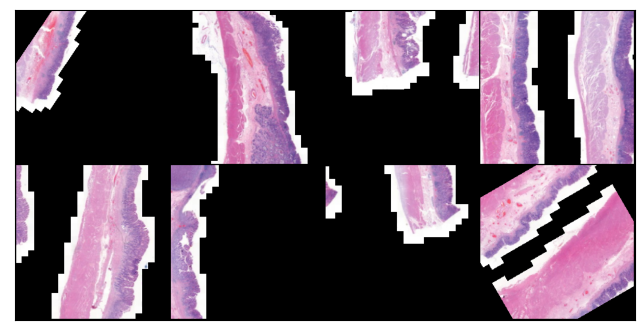

In [10]:
for img_patch, label_patch in train_loader:
    fig, img = plt.subplots(figsize = (8, 8))
    img.set_xticks([])
    img.set_yticks([])
    img.imshow(make_grid(img_patch,4).permute(1, 2, 0))
    break

In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

In [12]:
class UNet(nn.Module):
    def __init__(self, out_classes=1, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x

In [13]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = UNet()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)

In [14]:
def train(model, global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    
    for step, (images, labels) in enumerate(train_loader):
        step += 1
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = loss_function(outputs, labels)
        loss.backward()
        epoch_loss += loss.item()
        
        optimizer.step()
        optimizer.zero_grad()
        
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, epoch_loss/step)
        )
        
    if global_step % eval_num == 0 or global_step == max_iterations:
#         epoch_iterator_val = tqdm(
#             valid_loader, desc="Validate (X / X Steps) (loss=X.X)", dynamic_ncols=True
#         )
        dice_val, val_labels, val_outputs = validation(model)
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        metric_values.append(dice_val)
        plt.subplot(121)
        plt.plot(epoch_loss_values)
        plt.title(f'step #: {global_step}')
        plt.subplot(122)
        plt.plot(metric_values)
        plt.show()

        if dice_val > dice_val_best:
            dice_val_best = dice_val
            global_step_best = global_step
            torch.save(
                model.state_dict(), os.path.join( f"test2.pth")
            )
            print(
                "Model Was Saved ! Current Best Avg. IoU: {} Current Avg. IoU: {}".format(
                    dice_val_best, dice_val
                )
            )
        else:
            print(
                "Model Was Not Saved ! Current Best Avg. IoU: {} Current Avg. IoU: {}".format(
                    dice_val_best, dice_val
                )
            )

        show_result(val_labels, val_outputs, global_step)
    
    global_step += 1

    return global_step, dice_val_best, global_step_best

In [15]:
def validation(model):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, (images, labels) in enumerate(valid_loader):
            step += 1
            
            val_images = images.to(device)
            val_labels = labels.to(device)
            val_outputs = model(val_images)
            val_loss = loss_function(val_outputs, val_labels)
           
            dice_vals.append(val_loss.cpu())
#             epoch_iterator_val.set_description(
#                 "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, max_iterations, val_loss)
#             )
                  
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val, val_labels, val_outputs

In [16]:
def show_result(val_labels, val_outputs, global_step):
    plt.figure(2,figsize=(24,16))
    plt.subplot(131)
    plt.imshow(val_outputs[0,0,:,:].cpu())
    plt.title('prediction')
    plt.subplot(132)
    plt.imshow((val_outputs[0,0,:,:]>.5).cpu())
    plt.title('prediction > 0.5')
    plt.subplot(133)
    plt.imshow(val_labels[0,0,:,:].cpu())
    plt.title('label')
    tmpa = datetime.datetime.now().date()
    plt.savefig(f'Result/test2/{tmpa}_step_{global_step}.png')
    plt.close(2)

In [17]:
max_iterations =  25000
eval_num = 500

global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [ ]:
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        model, global_step, train_loader, dice_val_best, global_step_best
    )